# **Homework 3**

## 0. Preliminary Steps

### 0.1 Import libraries 

In [ ]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, Dataset
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import copy

### 0.2 Clone Repository

In [ ]:
# Clone github repository with data
if not os.path.isdir('./PACS'):
	!git clone https://github.com/rm-wu/Homework3-PACS.git
	!mv 'Homework3-PACS/PACS/' 'PACS'

### 0.3 Utils Funcitons

In [ ]:
def evaluate_test_set(model, test_dataloader, train=False):
    if train == False:
        model = model.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    model.train(False) # Set Network to evaluation mode
    
    criterion = nn.CrossEntropyLoss() 
    running_loss = 0.0
    running_corrects = 0
    for images, labels in test_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        batch_size = len(labels)

        # Forward Pass
        outputs, _ = model(images)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()
        loss = criterion(outputs, labels)
        running_loss += loss.item() * batch_size

    loss = running_loss / float(len(test_dataloader.dataset))

    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataloader.dataset))
    if train == False:
        model.to(DEVICE)
    print(f"Test Accuracy: {accuracy}\t Loss: {loss}")
    return loss, accuracy

In [ ]:
def save_results(result, filename):
    with open(filename, "w", encoding="utf-8") as f:
        f.write("loss, s_acc, target_loss, target_acc, s_loss, s_d_loss, t_d_loss\n")
        epochs = len(result["loss"])
        for i in range(epochs):
            f.write(f"{result['loss'][i]},{result['s_acc'][i]},{result['target_loss'][i]},{result['target_acc'][i]},{result['s_loss'][i]},{result['s_d_loss'][i]},{result['t_d_loss'][i]}\n")

In [ ]:

norm_imagenet_mean = (0.485, 0.456, 0.406)
norm_imagenet_std  = (0.229, 0.224, 0.225)

train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(norm_imagenet_mean, norm_imagenet_std) # Normalizes tensor with mean and standard deviation
])
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)                               
])
train_transform  = transforms.Compose([
                                    #transforms.RandomCrop(200),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.Resize((256, 256)),     
                                    transforms.CenterCrop(224),
                                    transforms.ColorJitter(hue=.05, saturation=.05),
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_imagenet_mean, norm_imagenet_std)])



## PACS Dataset

In [ ]:
dataset_dict = dict()
for domain in os.listdir('./PACS'):
    dataset_dict[domain] = torchvision.datasets.ImageFolder(f'./PACS/{domain}', transform=train_transform)
for k,v in dataset_dict.items():
    print(k,":", v)
    print()

photo : Dataset ImageFolder
    Number of datapoints: 1670
    Root location: ./PACS/photo
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ColorJitter(brightness=None, contrast=None, saturation=[0.95, 1.05], hue=[-0.05, 0.05])
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

sketch : Dataset ImageFolder
    Number of datapoints: 3929
    Root location: ./PACS/sketch
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ColorJitter(brightness=None, contrast=None, saturation=[0.95, 1.05], hue=[-0.05, 0.05])
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.22

In [ ]:
ll = list()
for _ in range(1670):
    ll.append(1)
for _ in range(2048):
    ll.append(2)
for _ in range(2344):
    ll.append(3)    
for _ in range(3929):
    ll.append(4)
np.array(ll)

array([1, 1, 1, ..., 4, 4, 4])

[1 1 1 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'PACS number of images per domain')

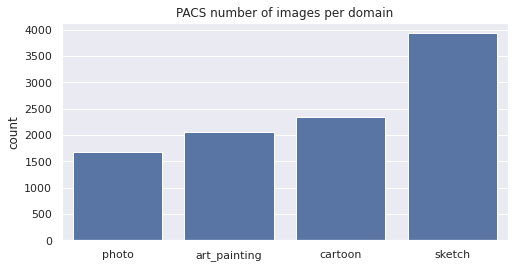

In [ ]:
y = np.array(ll) 
print(y)
fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(y, color='b')
ax.set(
      xticklabels=['photo', 'art_painting', 'cartoon', 'sketch'] )
ax.set_title(f"PACS number of images per domain")
#ax.xaxis.set_tick_params(rotation=90);

(1670,)
(2344,)
(2048,)
(3929,)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'PACS class distribution')

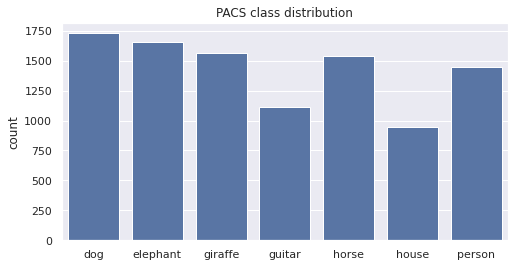

In [ ]:
y_tot = np.zeros(9991)
i = 0
for domain in ['photo', 'cartoon','art_painting', 'sketch']:
    y = dataset_dict[domain].targets
    print(np.array(y).shape)
    y_tot[i : i+len(y)] = y[:]
    i+=len(y)
fig, ax = plt.subplots(figsize=(8, 4))

sns.countplot(y_tot, color='b')
ax.set(
    #xticks=range(len(train_dataset_.categories)), 
    xticklabels=dataset_dict[domain].classes)
ax.set_title(f"PACS class distribution")
#ax.xaxis.set_tick_params(rotation=90);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn

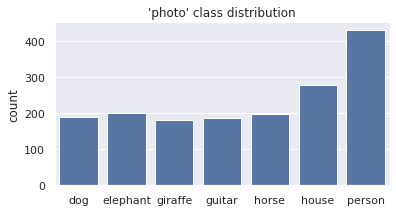

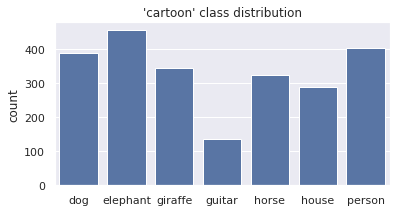

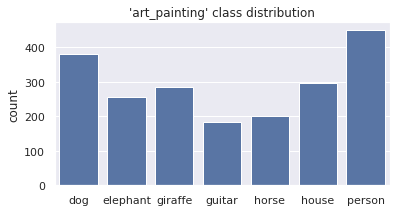

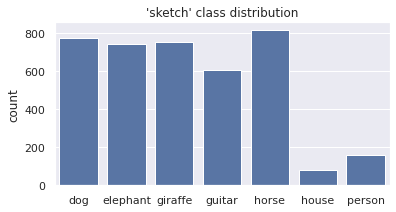

In [ ]:
for domain in ['photo', 'cartoon','art_painting', 'sketch']:
    y = dataset_dict[domain].targets
    fig, ax = plt.subplots(figsize=(6, 3))

    sns.countplot(y, color='b')
    ax.set(
        #xticks=range(len(train_dataset_.categories)), 
        xticklabels=dataset_dict[domain].classes)
    ax.set_title(f"'{domain}' class distribution")
    #ax.xaxis.set_tick_params(rotation=90);

## 2. DANN implementation

In [ ]:
import torch
import torchvision
from torch.autograd import Function
from torchvision.models import alexnet
from torch import nn

class ReverseLayerF(Function):
	@staticmethod
	def forward(ctx, x, alpha):
		ctx.alpha = alpha
		return x.view_as(x)
		
	@staticmethod
	def backward(ctx, grad_output):
		output = grad_output.neg() * ctx.alpha
		return output, None


class DANN(nn.Module):
	def __init__(self, 
			num_classes=7,
			domain_adaptation = True):
		super(DANN, self).__init__()
		self.features = nn.Sequential(
			nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
			nn.ReLU(inplace=True), 
			nn.MaxPool2d(kernel_size=3, stride=2),
			nn.Conv2d(64, 192, kernel_size=5, padding=2),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=3, stride=2),
			nn.Conv2d(192, 384, kernel_size=3, padding=1),
			nn.ReLU(inplace=True),
			nn.Conv2d(384, 256, kernel_size=3, padding=1),
			nn.ReLU(inplace=True),
			nn.Conv2d(256, 256, kernel_size=3, padding=1),
			nn.ReLU(inplace=True), 
			nn.MaxPool2d(kernel_size=3, stride=2),
		)
		
		self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
		
		self.classifier = nn.Sequential(
			nn.Dropout(),
			nn.Linear(256 * 6 * 6, 4096),
			nn.ReLU(inplace=True),
			nn.Dropout(),
			nn.Linear(4096, 4096),
			nn.ReLU(inplace=True),
			nn.Linear(4096, num_classes),
		)
		net = alexnet(pretrained=True)
		net.classifier[6] = nn.Linear(4096, num_classes)
		net_state = net.state_dict()
		self.load_state_dict(net_state, strict=False)
		
		self.domain_adaptation = domain_adaptation
		if self.domain_adaptation:
			self.discriminator = nn.Sequential(
				nn.Dropout(),
				nn.Linear(256 * 6 * 6, 4096),
				nn.ReLU(inplace=True),
				nn.Dropout(),
				nn.Linear(4096, 4096),
				nn.ReLU(inplace=True),
				nn.Linear(4096, 2)
			)
			
			for i in [1, 4]:
				self.discriminator[i].weight.data = net_state[f"classifier.{i}.weight"]
				self.discriminator[i].bias.data = net_state[f"classifier.{i}.bias"]
			
	def forward(self, x, target=False, alpha=None):
		x = self.features(x)
		x = self.avgpool(x)
		x = torch.flatten(x, 1)
		if self.domain_adaptation:
			if target:
				d = ReverseLayerF.apply(x, alpha)
				d = self.discriminator(d)
				return None, d
			else:
				y = self.classifier(x)
				d = ReverseLayerF.apply(x, alpha)
				d = self.discriminator(d)
				return y, d
		else:
			# No domanin adapatation
			y = self.classifier(x)
			return y, None

## 3.  DANN training


In [ ]:
DEVICE = 'cuda'

import math 


def train_model(dataloader, 
                config,
                domain_adaptation,
                save_weights=False, path=None,
                device='cuda'):    
    cudnn.benchmark = True
    model = DANN(domain_adaptation = domain_adaptation)
    model.to(device)
    criterion = nn.CrossEntropyLoss() 
    parameters_to_optimize = model.parameters() 
    if config['optimizer'] == 'SGD':
        optimizer = optim.SGD(parameters_to_optimize, 
                            lr=config['lr'], 
                            momentum=config['momentum'], 
                            weight_decay=config['wd'])

    best_model_w = copy.deepcopy(model.state_dict())
    
    if domain_adaptation:
        best_acc = 0.0
        best_loss = 1e9
        best_val_acc = 0.0
        best_s_loss, best_s_d_loss, best_t_d_loss = 0,0,0
        
        best_TA_acc, best_TA_loss = 0 ,0 
        best_TA_target_loss = 0.0

        train_info = {'s_loss':[], 
                      's_acc':[], 
                      's_d_loss':[], 
                      't_d_loss':[],
                      'loss':[], 
                      'target_loss':[],
                      'target_acc':[]}

        len_dataloader = min(len(dataloader['source'].dataset),
                             len(dataloader['target'].dataset))
        
        print(f"len_dataloader {len_dataloader}")

        alpha = config['alpha']
        num_epochs = config['num_epochs']
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print('=' * 50)
            model.train()
            
            s_running_loss = 0.0 
            s_running_corrects = 0.0
            s_running_d_loss = 0.0
            t_running_d_loss = 0.0
            running_loss = 0.0
            i = 0
            p = 0
            for s_data, t_data in zip(dataloader['source'], dataloader['target']):
                optimizer.zero_grad()
                
                s_img, s_label = s_data
                s_img, s_label = s_img.to(device), s_label.to(device)
                s_img = s_img.to()
                s_label = s_label.cuda()

                batch_size = len(s_label)
                
                #print(batch_size)

                s_d_label = torch.zeros(batch_size, dtype=torch.long, device=DEVICE)
                t_img, _ = t_data
                t_img = t_img.cuda()
                t_d_label = torch.ones(batch_size, dtype=torch.long, device=DEVICE)
                with torch.set_grad_enabled(True): # TODO: set to False if validation used later
                    s_y, s_d = model(s_img, target=False, alpha=alpha)
                    _, preds = torch.max(s_y.data, 1) #accuracy score
                    _, s_pred_d = torch.max(s_d.data, 1)
                    #print(torch.sum(preds == s_label.data))
                    #print(f"S {torch.sum(s_pred_d == s_d_label).item()}/{batch_size}")

                    s_loss_Gy = criterion(s_y, s_label)
                    s_loss_Gd = criterion(s_d, s_d_label)
                    s_loss = s_loss_Gd + s_loss_Gy
                    s_loss.backward()

                    _  , t_d = model(t_img, target=True, alpha=alpha)
                    
                    _, t_pred_d = torch.max(t_d.data, 1)
                    #print(f"T {torch.sum(t_pred_d == s_d_label).item()}/{batch_size}")
                    t_loss_Gd = criterion(t_d, t_d_label)
                    t_loss_Gd.backward()
                    optimizer.step()
                
                #print("s_loss ", s_running_loss, s_loss_Gy.item() * batch_size)
                s_running_loss += s_loss_Gy.item() * batch_size
                s_running_corrects += torch.sum(preds == s_label.data)

                #print("s_d_loss ",s_running_d_loss, s_loss_Gd.item() * batch_size)           
                s_running_d_loss += s_loss_Gd.item() * batch_size
                #print("t_d_loss ",t_running_d_loss, t_loss_Gd.item() * batch_size)
                t_running_d_loss += t_loss_Gd.item() * batch_size

                #print("total loss ", running_loss, (s_loss + t_loss_Gd).item() * batch_size)
                running_loss += (s_loss + t_loss_Gd).item() * batch_size
                #print(s_running_loss, s_running_d_loss, t_running_d_loss)
                
                i += 1 

            s_epoch_loss = s_running_loss / len_dataloader
            s_epoch_acc = s_running_corrects.double() / len_dataloader
            s_epoch_d_loss = s_running_d_loss / len_dataloader
            t_epoch_d_loss = t_running_d_loss / len_dataloader
            epoch_loss = running_loss / len_dataloader

            print(f"Network Loss:{epoch_loss:.4f}")
            print(f"acc: {s_epoch_acc:.4f}")
            print(f"Gy:\t{s_epoch_loss:.4f}")
            print(f"GdS:\t{s_epoch_d_loss:.4f}")
            print(f"GdT:\t{t_epoch_d_loss:.4f}")
            target_loss, target_acc = evaluate_test_set(model, dataloader['test'])
            print(f"Target Accuracy : {target_acc}\t Target Loss: {target_loss}")

            train_info['s_loss'].append(s_epoch_loss)
            train_info['s_acc'].append(s_epoch_acc)
            train_info['s_d_loss'].append(s_epoch_d_loss)
            train_info['t_d_loss'].append(t_epoch_d_loss)
            train_info['loss'].append(epoch_loss)
            train_info['target_acc'].append(target_acc)
            train_info['target_loss'].append(target_loss)
            if epoch_loss < best_loss:
                print(f"New Best Loss: {best_loss:.4f} -> {epoch_loss:.4f}")
                best_loss = epoch_loss
                best_acc = s_epoch_acc
                best_val_acc = target_acc
                best_s_loss = s_epoch_loss
                best_s_d_loss = s_epoch_d_loss
                best_t_d_loss = t_epoch_d_loss
                best_model_w = copy.deepcopy(model.state_dict())

            if target_acc > best_TA_acc:
                print(f"New Best TA: {best_TA_acc:.4f} -> {target_acc:.4f}")
                best_TA_acc = target_acc
                best_TA_loss = epoch_loss
                best_TA_target_loss = target_loss

            if math.isnan(epoch_loss):
                break
            #if scheduler is not None:
            #    scheduler.step()
        model.load_state_dict(best_model_w)
        evaluate_test_set(model, test_dataloader, train=True)
        print(f"Best train Loss {best_loss:.4f} ")
        print(f"{best_loss}\t{best_acc}\t{best_val_acc}")
        print()
        print(f"{best_TA_acc}\t{best_TA_loss}")
        print(f"{best_s_loss}\t{best_s_d_loss}\t{best_t_d_loss}")
        model.to('cpu')
    else:
        best_acc = 0.0
        best_loss = 1e9
        best_val_acc = 0.0
        best_s_loss, best_s_d_loss, best_t_d_loss = 0,0,0
        
        best_TA_acc, best_TA_loss = 0 ,0 
        best_TA_target_loss = 0.0

        train_info = {'s_loss':[], 
                      's_acc':[], 
                      'loss':[], 
                      'target_loss':[],
                      'target_acc':[]}

        len_dataloader = min(len(dataloader['source'].dataset),
                             len(dataloader['target'].dataset))
        
        print(f"len_dataloader {len_dataloader}")

        #alpha = config['alpha']
        num_epochs = config['num_epochs']
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print('=' * 50)
            model.train()
            
            s_running_loss = 0.0 
            s_running_corrects = 0.0
            s_running_d_loss = 0.0
            # t_running_d_loss = 0.0
            running_loss = 0.0
            i = 0
            p = 0
            for s_data, t_data in zip(dataloader['source'], dataloader['target']):
                alpha = 0.1
                #p = float(i + epoch*len_dataloader) / num_epochs / len_dataloader
                #alpha = 2. / (1. + np.exp(-10 * p)) - 1
                #alpha = alpha_ / (1. + np.exp(-10 * p)) - 1
                #print(alpha)

                #optimizer = optimizer_scheduler(optimizer, p)
                optimizer.zero_grad()
                
                s_img, s_label = s_data
                s_img, s_label = s_img.to(device), s_label.to(device)
                s_img = s_img.to()
                s_label = s_label.cuda()

                batch_size = len(s_label)
                
                #print(batch_size)

                t_img, _ = t_data
                t_img = t_img.cuda()

                with torch.set_grad_enabled(True): # TODO: set to False if validation used later
                    s_y, _ = model(s_img)
                    _, preds = torch.max(s_y.data, 1) #accuracy score
                    
                    s_loss_Gy = criterion(s_y, s_label)

                    s_loss = s_loss_Gy
                    s_loss.backward()

                    
                    optimizer.step()
                
                #print("s_loss ", s_running_loss, s_loss_Gy.item() * batch_size)
                s_running_loss += s_loss_Gy.item() * batch_size
                s_running_corrects += torch.sum(preds == s_label.data)
                

                #print("total loss ", running_loss, (s_loss + t_loss_Gd).item() * batch_size)
                running_loss += (s_loss).item() * batch_size
                #print(s_running_loss, s_running_d_loss, t_running_d_loss)
                
                i += 1 

            s_epoch_loss = s_running_loss / len_dataloader
            s_epoch_acc = s_running_corrects.double() / len_dataloader
            epoch_loss = running_loss / len_dataloader

            print(f"Network Loss:{epoch_loss:.4f}")
            print(f"acc: {s_epoch_acc:.4f}")
            target_loss, target_acc = evaluate_test_set(model, dataloader['test'])
            print(f"Target Accuracy : {target_acc}\t Target Loss: {target_loss}")

            train_info['s_loss'].append(s_epoch_loss)
            train_info['s_acc'].append(s_epoch_acc)
            train_info['loss'].append(epoch_loss)
            train_info['target_acc'].append(target_acc)
            train_info['target_loss'].append(target_loss)
            if epoch_loss < best_loss:
                print(f"New Best Loss: {best_loss:.4f} -> {epoch_loss:.4f}")
                best_loss = epoch_loss
                best_acc = s_epoch_acc
                best_val_acc = target_acc
                best_s_loss = s_epoch_loss
                best_model_w = copy.deepcopy(model.state_dict())

            if target_acc > best_TA_acc:
                print(f"New Best TA: {best_TA_acc:.4f} -> {target_acc:.4f}")
                best_TA_acc = target_acc
                best_TA_loss = epoch_loss
                best_TA_target_loss = target_loss

            if math.isnan(epoch_loss):
                break

        model.load_state_dict(best_model_w)
        evaluate_test_set(model, test_dataloader, train=True)
        print(f"Best train Loss {best_loss:.4f} ")
        print(f"{best_loss}\t{best_acc}\t{best_val_acc}")
        print()
        print(f"{best_TA_acc}\t{best_TA_loss}")
        print(f"{best_s_loss}\t{best_s_d_loss}\t{best_t_d_loss}")
        model.to('cpu')
    print()
    return model, train_info


In [ ]:
LR = 1e-4         # The initial Learning Rate
MOMENTUM = 0.9      # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-3 # Regularization, you can keep this at the default

NUM_EPOCHS = 30     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1         # Multiplicative factor for learning rate step-down

BATCH_SIZE = 256

LR = 0.01	
WEIGHT_DECAY = 0.00010	
alpha = 0.1

## Point 3: 

### Point 3.A : P -> A GridSearch without DANN training 

#### 3.A.1: GridSearch

In [ ]:
param_grid = {
              'lr': [1e-2, 5e-3, 1e-3],
              'wd':[5e-5, 5e-4]
              }

source = 'photo'
target = 'cartoon'

test_dataset = torchvision.datasets.ImageFolder(f'./PACS/{domain}', transform=eval_transform)
test_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

source_dataloader = DataLoader(dataset_dict[source], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
dataloader = {'source': source_dataloader, 
              'target': target_dataloader, 
              'test':test_dataloader}

In [ ]:
for params in ParameterGrid(param_grid):
    print(params)
    config = {
        'optimizer':'SGD',
        'lr':params['lr'],
        'momentum':0.9,
        'wd':params['wd'], 
        'num_epochs': int(30),
        #'alpha':params['alpha']
    }
    print(config)

    model_, res = train_model(dataloader, 
                config, 
                domain_adaptation = False )

    save_results(res, os.path.join('./drive/MyDrive/HW3/', f"AN_PA_{config['lr']}_{config['wd']}.csv"))
 
    print()
    print()

### Point 3.B: P -> A GridSearch with DANN training 

#### 3.B.1 GridSearch

In [ ]:
param_grid = {
              'lr': [1e-2, 5e-3, 1e-3],
              'wd':[5e-5, 5e-4], 
              'alpha':[0.01, 0.05, 0.1, 0.15, 0.2]}

source = 'photo'
target = 'art_painting'

test_dataset = torchvision.datasets.ImageFolder(f'./PACS/{domain}', transform=eval_transform)
test_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

source_dataloader = DataLoader(dataset_dict[source], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
dataloader = {'source': source_dataloader, 
              'target': target_dataloader, 
              'test':test_dataloader}


In [ ]:
for params in ParameterGrid(param_grid):
    print(params)
    config = {
        'optimizer':'SGD',
        'lr':params['lr'],
        'momentum':0.9,
        'wd':params['wd'], 
        'num_epochs': int(30),
        'alpha':params['alpha']
    }
    print(config)

    model_, res = train_model(dataloader, 
                config, domain_adaptation=True)

    save_results(res, os.path.join('./drive/MyDrive/HW3/', f"1_{config['alpha']}_{config['lr']}_{config['wd']}.csv"))
 
    print()
    print()

Output streaming troncato alle ultime 5000 righe.
New Best Loss: 0.3284 -> 0.2869

Epoch 14/30
Network Loss:0.2761
acc: 0.9108
Gy:	0.0277
GdS:	0.1262
GdT:	0.1221
Test Accuracy: 0.5205078125	 Loss: 2.7526539862155914
Target Accuracy : 0.5205078125	 Target Loss: 2.7526539862155914
New Best Loss: 0.2869 -> 0.2761
New Best TA: 0.5044 -> 0.5205

Epoch 15/30
Network Loss:0.2499
acc: 0.9144
Gy:	0.0175
GdS:	0.1234
GdT:	0.1090
Test Accuracy: 0.4775390625	 Loss: 3.208551436662674
Target Accuracy : 0.4775390625	 Target Loss: 3.208551436662674
New Best Loss: 0.2761 -> 0.2499

Epoch 16/30
Network Loss:0.2315
acc: 0.9138
Gy:	0.0214
GdS:	0.0924
GdT:	0.1177
Test Accuracy: 0.49072265625	 Loss: 3.4196255281567574
Target Accuracy : 0.49072265625	 Target Loss: 3.4196255281567574
New Best Loss: 0.2499 -> 0.2315

Epoch 17/30
Network Loss:0.2293
acc: 0.9138
Gy:	0.0153
GdS:	0.1302
GdT:	0.0838
Test Accuracy: 0.509765625	 Loss: 3.379738062620163
Target Accuracy : 0.509765625	 Target Loss: 3.379738062620163
New 

## Point 4: Validation using Cartoon and Sketch Dataset

### Point 4.A: Training without DANN


#### 4.A.1 Photo to Cartoon

In [ ]:
param_grid = {
              'lr': [1e-2, 5e-3, 1e-3],
              'wd':[5e-5, 5e-4]
              }

source = 'photo'
target = 'cartoon'

test_dataset = torchvision.datasets.ImageFolder(f'./PACS/{domain}', transform=eval_transform)
test_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

source_dataloader = DataLoader(dataset_dict[source], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
dataloader = {'source': source_dataloader, 
              'target': target_dataloader, 
              'test':test_dataloader}


In [ ]:
for params in ParameterGrid(param_grid):
    print(params)
    config = {
        'optimizer':'SGD',
        'lr':params['lr'],
        'momentum':0.9,
        'wd':params['wd'], 
        'num_epochs': int(30)
    }
    print(config)

    model_, res = train_model(dataloader, 
                config, domain_adaptation=False)
    
    save_results(res, os.path.join('./drive/MyDrive/HW3/', f"AN_PC_{config['lr']}_{config['wd']}.csv"))
 
    print()
    print()

#### 4.A.2 Photo to Sketch

In [ ]:
param_grid = {
              'lr': [1e-2, 5e-3, 1e-3],
              'wd':[5e-5, 5e-4]
              }

source = 'photo'
target = 'sketch'

test_dataset = torchvision.datasets.ImageFolder(f'./PACS/{domain}', transform=eval_transform)
test_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

source_dataloader = DataLoader(dataset_dict[source], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
dataloader = {'source': source_dataloader, 
              'target': target_dataloader, 
              'test':test_dataloader}

In [ ]:
for params in ParameterGrid(param_grid):
    print(params)
    config = {
        'optimizer':'SGD',
        'lr':params['lr'],
        'momentum':0.9,
        'wd':params['wd'], 
        'num_epochs': int(30),
        'alpha':params['alpha']
    }
    print(config)

    model_, res = train_model(dataloader, 
                config, domain_adaptation=False)

    save_results(res, os.path.join('./drive/MyDrive/HW3/', f"AN_PS_{config['lr']}_{config['wd']}.csv"))
 
    print()
    print()

#### 4.A.3: Best hyperparameters on Photo to Art

In [ ]:
target = 'art_painting'
test_dataset = torchvision.datasets.ImageFolder(f'./PACS/{domain}', transform=eval_transform)
test_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
target_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
dataloader = {'source': source_dataloader, 
              'target': target_dataloader, 
              'test':test_dataloader}

config = {
        'optimizer':'SGD',
        'lr':1e-2,
        'momentum':0.9,
        'wd':5e-5, 
        'num_epochs': 8,
        'alpha':params['alpha']
    }
print(config)

model_, res = train_model(dataloader, 
            config, domain_adaptation=False)
save_results(res, os.path.join('./drive/MyDrive/HW3/', f"AN_PA_4_{config['lr']}_{config['wd']}.csv"))

### Point 4.B: Training  with DANN

#### 4.B.1 Photo to Cartoon


In [ ]:
param_grid = {
              'lr': [1e-2, 5e-3, 1e-3],
              'wd':[5e-5, 5e-4], 
              'alpha':[0.01, 0.05, 0.1, 0.15, 0.2]}

source = 'photo'
target = 'cartoon'

test_dataset = torchvision.datasets.ImageFolder(f'./PACS/{domain}', transform=eval_transform)
test_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

source_dataloader = DataLoader(dataset_dict[source], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
dataloader = {'source': source_dataloader, 
              'target': target_dataloader, 
              'test':test_dataloader}

In [ ]:
for params in ParameterGrid(param_grid):
    print(params)
    config = {
        'optimizer':'SGD',
        'lr':params['lr'],
        'momentum':0.9,
        'wd':params['wd'], 
        'num_epochs': int(30),
        'alpha':params['alpha']
    }
    print(config)

    model_, res = train_model(dataloader, 
                config, domain_adaptation=True)

    save_results(res, os.path.join('./drive/MyDrive/HW3/', f"DANN_PC_{config['alpha']}_{config['lr']}_{config['wd']}.csv"))
 
    print()
    print()

#### 4.B.2 Photo to Sketch

In [ ]:
param_grid = {
              'lr': [1e-2, 5e-3, 1e-3],
              'wd':[5e-5, 5e-4], 
              'alpha':[0.01, 0.05, 0.1, 0.15, 0.2]}

source = 'photo'
target = 'sketch'

test_dataset = torchvision.datasets.ImageFolder(f'./PACS/{domain}', transform=eval_transform)
test_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

source_dataloader = DataLoader(dataset_dict[source], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
dataloader = {'source': source_dataloader, 
              'target': target_dataloader, 
              'test':test_dataloader}


In [ ]:
for params in ParameterGrid(param_grid):
    print(params)
    config = {
        'optimizer':'SGD',
        'lr':params['lr'],
        'momentum':0.9,
        'wd':params['wd'], 
        'num_epochs': int(30),
        'alpha':params['alpha']
    }
    print(config)

    model_, res = train_model(dataloader, 
                config, domain_adaptation=True)

    save_results(res, os.path.join('./drive/MyDrive/HW3/', f"DANN_PS_{config['alpha']}_{config['lr']}_{config['wd']}.csv"))
 
    print()
    print()

#### 4.B.3 Best hyperparameters on Photo to Art

In [ ]:
target = 'art_painting'
test_dataset = torchvision.datasets.ImageFolder(f'./PACS/{domain}', transform=eval_transform)
test_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
target_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
dataloader = {'source': source_dataloader, 
              'target': target_dataloader, 
              'test':test_dataloader}
config = {
        'optimizer':'SGD',
        'lr':1e-2,
        'momentum':0.9,
        'wd':5e-5, 
        'num_epochs': 22,
        'alpha':0.05
    }
print(config)

model_, res = train_model(dataloader, 
            config, domain_adaptation=False)
save_results(res, os.path.join('./drive/MyDrive/HW3/', f"DANN_PA_4_{config['alpha']}_{config['lr']}_{config['wd']}.csv"))


## Extra Point :  Dynamic Alpha and LR scheduler

In [ ]:
DEVICE = 'cuda'

import math 

def optimizer_scheduler(optimizer, p, 
                        mu_0=1e-2,
                        beta=0.75, 
                        alpha_=10):
    print(f"lr {mu_0 / (1. + alpha_ * p) ** beta} {mu_0}")
    for param_group in optimizer.param_groups:
        param_group['lr'] = mu_0 / (1. + alpha_ * p) ** beta
    return optimizer



def train_model_dyn(dataloader, 
                config,
                domain_adaptation,
                DANN_optim = False,
                save_weights=False, path=None,
                device='cuda'):    
    cudnn.benchmark = True
    model = DANN(domain_adaptation = domain_adaptation)
    model.to(device)
    criterion = nn.CrossEntropyLoss() 
    parameters_to_optimize = model.parameters() 
    if config['optimizer'] == 'SGD':
        optimizer = optim.SGD(parameters_to_optimize, 
                            lr=config['lr'], 
                            momentum=config['momentum'], 
                            weight_decay=config['wd'])

    best_model_w = copy.deepcopy(model.state_dict())
    
    if domain_adaptation:
        best_acc = 0.0
        best_loss = 1e9
        best_val_acc = 0.0
        best_s_loss, best_s_d_loss, best_t_d_loss = 0,0,0
        
        best_TA_acc, best_TA_loss = 0 ,0 
        best_TA_target_loss = 0.0

        train_info = {'s_loss':[], 
                      's_acc':[], 
                      's_d_loss':[], 
                      't_d_loss':[],
                      'loss':[], 
                      'target_loss':[],
                      'target_acc':[]}

        len_dataloader = min(len(dataloader['source'].dataset),
                             len(dataloader['target'].dataset))
        
        print(f"len_dataloader {len_dataloader}")

        # alpha = config['alpha'] # NODYN
        num_epochs = config['num_epochs']
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print('=' * 50)
            model.train()
            
            s_running_loss = 0.0 
            s_running_corrects = 0.0
            s_running_d_loss = 0.0
            t_running_d_loss = 0.0
            running_loss = 0.0
            i = 0
            p = 0
            b_s = 0
            for s_data, t_data in zip(dataloader['source'], dataloader['target']):
                s_img, s_label = s_data
                s_img, s_label = s_img.to(device), s_label.to(device)
                s_img = s_img.to()
                s_label = s_label.cuda()

                batch_size = len(s_label)
                
                #alpha = 0.1
                #p = float(i + epoch*len_dataloader) / num_epochs / len_dataloader
                #p = float(b_s + epoch*len_dataloader) / num_epochs / len_dataloader
                p = float( epoch*len_dataloader) / num_epochs / len_dataloader
                print(f"p : {b_s + epoch*len_dataloader}/{num_epochs*len_dataloader} = {p}")
                b_s += batch_size

                alpha = (2. / (1. + np.exp(-10 * p)) - 1) * config['alpha']
                #alpha = 1.5 / (1. + np.exp(-10 * p)) - 1
                print(alpha)

                #optimizer = optimizer_scheduler(optimizer, p)
                if config['lr_scheduler']:
                    optimizer = optimizer_scheduler(optimizer, p, mu_0 = config['lr'])
                optimizer.zero_grad()
                
                
                #print(batch_size)

                s_d_label = torch.zeros(batch_size, dtype=torch.long, device=DEVICE)
                t_img, _ = t_data
                t_img = t_img.cuda()
                t_d_label = torch.ones(batch_size, dtype=torch.long, device=DEVICE)
                with torch.set_grad_enabled(True): # TODO: set to False if validation used later
                    s_y, s_d = model(s_img, target=False, alpha=alpha)
                    _, preds = torch.max(s_y.data, 1) #accuracy score
                    _, s_pred_d = torch.max(s_d.data, 1)
                    #print(torch.sum(preds == s_label.data))
                    #print(f"S {torch.sum(s_pred_d == s_d_label).item()}/{batch_size}")

                    s_loss_Gy = criterion(s_y, s_label)
                    s_loss_Gd = criterion(s_d, s_d_label)
                    s_loss = s_loss_Gd + s_loss_Gy
                    s_loss.backward()

                    _  , t_d = model(t_img, target=True, alpha=alpha)
                    
                    _, t_pred_d = torch.max(t_d.data, 1)
                    #print(f"T {torch.sum(t_pred_d == s_d_label).item()}/{batch_size}")
                    t_loss_Gd = criterion(t_d, t_d_label)
                    t_loss_Gd.backward()
                    optimizer.step()
                
                #print("s_loss ", s_running_loss, s_loss_Gy.item() * batch_size)
                s_running_loss += s_loss_Gy.item() * batch_size
                s_running_corrects += torch.sum(preds == s_label.data)

                #print("s_d_loss ",s_running_d_loss, s_loss_Gd.item() * batch_size)           
                s_running_d_loss += s_loss_Gd.item() * batch_size
                #print("t_d_loss ",t_running_d_loss, t_loss_Gd.item() * batch_size)
                t_running_d_loss += t_loss_Gd.item() * batch_size

                #print("total loss ", running_loss, (s_loss + t_loss_Gd).item() * batch_size)
                running_loss += (s_loss + t_loss_Gd).item() * batch_size
                #print(s_running_loss, s_running_d_loss, t_running_d_loss)
                
                i += 1 

            s_epoch_loss = s_running_loss / len_dataloader
            s_epoch_acc = s_running_corrects.double() / len_dataloader
            s_epoch_d_loss = s_running_d_loss / len_dataloader
            t_epoch_d_loss = t_running_d_loss / len_dataloader
            epoch_loss = running_loss / len_dataloader

            print(f"Network Loss:{epoch_loss:.4f}")
            print(f"acc: {s_epoch_acc:.4f}")
            print(f"Gy:\t{s_epoch_loss:.4f}")
            print(f"GdS:\t{s_epoch_d_loss:.4f}")
            print(f"GdT:\t{t_epoch_d_loss:.4f}")
            target_loss, target_acc = evaluate_test_set(model, dataloader['test'])
            print(f"Target Accuracy : {target_acc}\t Target Loss: {target_loss}")

            train_info['s_loss'].append(s_epoch_loss)
            train_info['s_acc'].append(s_epoch_acc)
            train_info['s_d_loss'].append(s_epoch_d_loss)
            train_info['t_d_loss'].append(t_epoch_d_loss)
            train_info['loss'].append(epoch_loss)
            train_info['target_acc'].append(target_acc)
            train_info['target_loss'].append(target_loss)
            if epoch_loss < best_loss:
                print(f"New Best Loss: {best_loss:.4f} -> {epoch_loss:.4f}")
                best_loss = epoch_loss
                best_acc = s_epoch_acc
                best_val_acc = target_acc
                best_s_loss = s_epoch_loss
                best_s_d_loss = s_epoch_d_loss
                best_t_d_loss = t_epoch_d_loss
                best_model_w = copy.deepcopy(model.state_dict())

            if target_acc > best_TA_acc:
                print(f"New Best TA: {best_TA_acc:.4f} -> {target_acc:.4f}")
                best_TA_acc = target_acc
                best_TA_loss = epoch_loss
                best_TA_target_loss = target_loss

            if math.isnan(epoch_loss):
                break

            print()
            
            #optimizer = optimizer_scheduler(optimizer, p)

            #if scheduler is not None:
            #    scheduler.step()
        model.load_state_dict(best_model_w)
        evaluate_test_set(model, test_dataloader, train=True)
        print(f"Best train Loss {best_loss:.4f} ")
        print(f"{best_loss}\t{best_acc}\t{best_val_acc}")
        print()
        print(f"{best_TA_acc}\t{best_TA_loss}")
        print(f"{best_s_loss}\t{best_s_d_loss}\t{best_t_d_loss}")
        model.to('cpu')
    print()
    return model, train_info


### Extra.1 : Photo -> Cartoon

In [ ]:
param_grid = {
              'lr': [1e-2, 5e-3, 1e-3],
              'wd':[5e-5, 5e-4],
              'lr_scheduler':[True, False],
              'alpha':[0.01, 0.1, 0.2, 0.5, 0.7, 1]
              #'alpha':[ 0.05, 0.15, 0.2]
              }

source = 'photo'
target = 'cartoon'

test_dataset = torchvision.datasets.ImageFolder(f'./PACS/{domain}', transform=eval_transform)
test_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

source_dataloader = DataLoader(dataset_dict[source], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
dataloader = {'source': source_dataloader, 
              'target': target_dataloader, 
              'test':test_dataloader}


In [ ]:
for params in ParameterGrid(param_grid):
    print(params)
    config = {
        'optimizer':'SGD',
        'lr':params['lr'],
        'momentum':0.9,
        'wd':params['wd'], 
        'num_epochs': int(30),
        'alpha':params['alpha'],
        'lr_scheduler':params['lr_scheduler']
    }
    print(config)

    model_, res = train_model_dyn(dataloader, 
                config, domain_adaptation=True)

    #print(f"model {i} LR: {lr}")
    #model, train_logs, val_logs = train_model(net,
    #                         dataloader,
    #                         config
    #                         )
    #res = {'train': train_logs, 'val':val_logs}
    
    if params['lr_scheduler']:
        save_results(res, os.path.join('./drive/MyDrive/HW3/', f"DYN_PC_lr_{config['alpha']}_{config['lr']}_{config['wd']}.csv"))
    else:
        save_results(res, os.path.join('./drive/MyDrive/HW3/', f"DYN_PC_{config['alpha']}_{config['lr']}_{config['wd']}.csv"))
    print()
    print()

### Extra.2 : Photo -> Cartoon

In [ ]:
param_grid = {
              'lr': [1e-2, 5e-3, 1e-3],
              'wd':[5e-5, 5e-4],
              'lr_scheduler':[True, False],
              'alpha':[0.01, 0.1, 0.2, 0.5, 0.7, 1]
              #'alpha':[ 0.05, 0.15, 0.2]
              }

source = 'photo'
target = 'cartoon'

test_dataset = torchvision.datasets.ImageFolder(f'./PACS/{domain}', transform=eval_transform)
test_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

source_dataloader = DataLoader(dataset_dict[source], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(dataset_dict[target], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
dataloader = {'source': source_dataloader, 
              'target': target_dataloader, 
              'test':test_dataloader}


In [ ]:
for params in ParameterGrid(param_grid):
    print(params)
    config = {
        'optimizer':'SGD',
        'lr':params['lr'],
        'momentum':0.9,
        'wd':params['wd'], 
        'num_epochs': 30,
        'alpha':params['alpha'],
        'lr_scheduler':params['lr_scheduler']
    }
    print(config)

    model_, res = train_model_dyn(dataloader, 
                config, domain_adaptation=True)
    
    if params['lr_scheduler']:
        save_results(res, os.path.join('./drive/MyDrive/HW3/', f"DYN_PS_lr_{config['alpha']}_{config['lr']}_{config['wd']}.csv"))
    else:
        save_results(res, os.path.join('./drive/MyDrive/HW3/', f"DYN_PS_{config['alpha']}_{config['lr']}_{config['wd']}.csv"))
    print()
    print()

### Extra.3: Best hyperparameters

In [ ]:
config = {
    'optimizer':'SGD',
    'lr': 1e-2,
    'momentum':0.9,
    'wd': 5e-4, 
    'num_epochs': 9,
    'alpha': 0.10,
    'lr_scheduler':False
}

model_, res = train_model_dyn(dataloader, 
            config, domain_adaptation=True)
save_results(res, os.path.join('./drive/MyDrive/HW3/', f"DYN_PA_{config['alpha']}_{config['lr']}_{config['wd']}.csv"))

In [ ]:
config = {
    'optimizer':'SGD',
    'lr': 1e-2,
    'momentum':0.9,
    'wd': 5e-4, 
    'num_epochs': 30,
    'alpha': 0.10,
    'lr_scheduler':True
}

model_, res = train_model_dyn(dataloader, 
            config, domain_adaptation=True)
save_results(res, os.path.join('./drive/MyDrive/HW3/', f"DYN_PA_lr_{config['alpha']}_{config['lr']}_{config['wd']}.csv"))